In [1]:
from graphviz import Digraph
from collections import OrderedDict

import spacy
nlp = spacy.load('en') 

In [22]:
test_sent = nlp("""It is also recognised that the body of the receptacle can be configured to include only one resilient arm that is biased with respect to the wall of the body, thus facilitating the retention of the stylus between the one arm and the wall (and/or other rigid secondary structures of the body).""")

To have a more completed graph each node has a unique ID that is generated from a label. This ID is used to index the node in properties dict.

node_properties[nodeID] = {
'label': X,
'root token': Y,
'tokens': Z
}

Do we also want a 'node' class?

In [136]:
class Node(object):
    """ Node in a graph. """
    
    def __init__(self, label, root_token=None):
        """ Initialise a node."""
        self.label = label
        self.root_token = root_token
        self.tokens = [root_token]
        
    def __repr__(self):
        return self.label

    
class Graph(object):
    """ Based on object here - https://www.python-course.eu/graphs_python.php"""
    
    def __init__(self, spacy_token=None):
        """ initializes a graph object 
            If no dictionary or None is given, 
            an empty dictionary will be used
        """
        # Can we split this between 3 variables - nodes, root_token, all_tokens?
        self.__graph_dict = OrderedDict()
        if spacy_token:
            self.build_graph(spacy_token)

    @property
    def nodes(self):
        """ returns the nodes of a graph """
        return list(self.__graph_dict.keys())

    @property
    def edges(self):
        """ returns the edges of a graph """
        return self.__generate_edges()
    
    @property
    def node_labels(self):
        """ Return all node labels."""
        return [n.label for n in self.nodes]

    def add_node(self, node_label, token=None):
        """ If the node "node" is not in 
            self.__graph_dict, a key "node" with an empty
            list as a value is added to the dictionary. 
            Otherwise nothing has to be done. 
        """
        if node_label not in self.node_labels:
            # Create a new node from the label
            node = Node(node_label, token)
            self.__graph_dict[node] = []
            return node
        else:
            for node in self.nodes:
                if node_label == node.label:
                    return node

    def add_edge(self, edge):
        """ assumes that edge is of type set, tuple or list; 
            between two nodes can be multiple edges! 
        """
        (node1, node2) = tuple(edge)
        if not isinstance(node1, Node):
            # Check for prexisting
            node1 = self.add_node(node1)
        if not isinstance(node2, Node):
            # Check for prexisting
            node2 = self.add_node(node2)
        if node1 in self.__graph_dict:
            self.__graph_dict[node1].append(node2)
        else:
            self.__graph_dict[node1] = [node2]

    def __generate_edges(self):
        """ A static method generating the edges of the 
            graph "graph". Edges are represented as sets 
            with one (a loop back to the node) or two 
            node 
        """
        edges = []
        for node in self.__graph_dict:
            for neighbour in self.__graph_dict[node]:
                if (neighbour, node) not in edges:
                    edges.append((node, neighbour))
        return edges

    def __str__(self):
        res = "nodes: "
        for k in self.__graph_dict:
            res += str(k) + " "
        res += "\nedges: "
        for edge in self.__generate_edges():
            res += str(edge) + " "
        return res
    
    def merge_nodes(self, parent_node, child_node):
        """Merge child node into parent node"""
        # Merge labels and tokens of child into parent
        parent_node.tokens = parent_node.tokens + child_node.tokens
        # Sort parent_node tokens
        parent_node.tokens.sort(key=lambda token: token.i)
        parent_node.label = " ".join([
            "{0}_{1}_{2}_{3}".format(token.text, token.tag_, token.dep_, token.i)
            for token in parent_node.tokens
            ])
        #self.remove_node(child_node)
        return parent_node
    
    def remove_node(self, node):
        """ Delete a node. """
        self.__graph_dict.pop(node, None)
        # Also remove from all entries of graph_dict
        for existing_node, entries in self.__graph_dict.items():
            if node in entries:
                self.__graph_dict[existing_node].remove(node)
    
    def remove_edge(self, edge):
        pass
    
    def get_graphviz(self):
        """ Visualise via Graphviz."""
        gv = Digraph()
        for node in self.nodes:
            gv.node(node.label)
        for node1, node2 in self.edges:
            gv.edge(node1.label, node2.label)
        return gv
    
    def build_graph(self, token):
        """ Print a graph ."""
        # Add node to graph
        node_name = "{0}_{1}_{2}_{3}".format(token.text, token.tag_, token.dep_, token.i)
        self.add_node(node_name, token)
        for child in token.children:
            child_name = self.build_graph(child)
            self.add_edge((node_name, child_name))
        return node_name
    
    def flatten_graph(self):
        """ Merge nodes with no children into parent node."""
        nodes_to_pop = []
        for node in self.nodes:
            # Get nodes connected to current node
            children = self.__graph_dict[node]
            for child in children:
                # If connected node has no children
                if not self.__graph_dict[child]:
                    self.merge_nodes(node, child)
                    nodes_to_pop.append(child)
        for ntp in nodes_to_pop:
            self.remove_node(ntp)

In [137]:
root = list(test_sent.sents)[0].root
g = Graph(root)

In [138]:
g.node_labels

['recognised_VBN_ROOT_3',
 'It_PRP_nsubjpass_0',
 'is_VBZ_auxpass_1',
 'also_RB_advmod_2',
 'configured_VBN_ccomp_12',
 'that_IN_mark_4',
 'body_NN_nsubjpass_6',
 'the_DT_det_5',
 'of_IN_prep_7',
 'receptacle_NN_pobj_9',
 'the_DT_det_8',
 'can_MD_aux_10',
 'be_VB_auxpass_11',
 'include_VB_xcomp_14',
 'to_TO_aux_13',
 'arm_NN_dobj_18',
 'one_CD_nummod_16',
 'only_RB_advmod_15',
 'resilient_JJ_amod_17',
 'biased_VBN_relcl_21',
 'that_WDT_nsubjpass_19',
 'is_VBZ_auxpass_20',
 'with_IN_prep_22',
 'respect_NN_pobj_23',
 'to_IN_prep_24',
 'wall_NN_pobj_26',
 'the_DT_det_25',
 'of_IN_prep_27',
 'body_NN_pobj_29',
 'the_DT_det_28',
 ',_,_punct_30',
 'facilitating_VBG_advcl_32',
 'thus_RB_advmod_31',
 'retention_NN_dobj_34',
 'the_DT_det_33',
 'of_IN_prep_35',
 'stylus_NN_pobj_37',
 'the_DT_det_36',
 'between_IN_prep_38',
 'arm_NN_pobj_41',
 'the_DT_det_39',
 'one_CD_nummod_40',
 'and_CC_cc_42',
 'wall_NN_conj_44',
 'the_DT_det_43',
 '(_-LRB-_punct_45',
 'and/or_CC_cc_46',
 'structures_NNS_conj

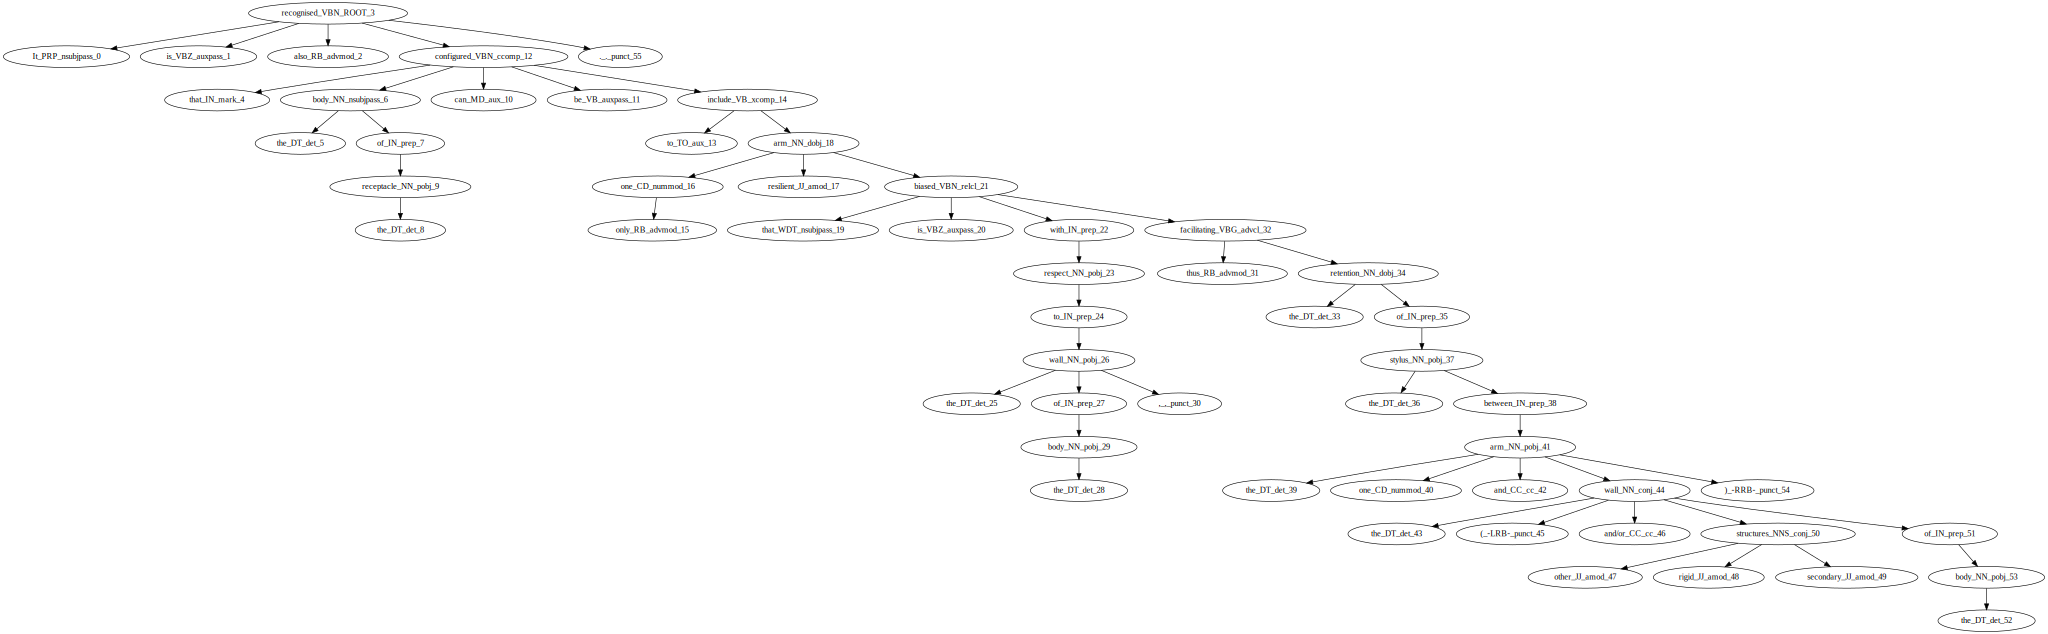

In [139]:
g.get_graphviz()

In [25]:
g._Graph__graph_dict

OrderedDict([('recognised_VBN_ROOT_3',
              ['It_PRP_nsubjpass_0',
               'is_VBZ_auxpass_1',
               'also_RB_advmod_2',
               'configured_VBN_ccomp_12',
               '._._punct_55']),
             ('It_PRP_nsubjpass_0', []),
             ('is_VBZ_auxpass_1', []),
             ('also_RB_advmod_2', []),
             ('configured_VBN_ccomp_12',
              ['that_IN_mark_4',
               'body_NN_nsubjpass_6',
               'can_MD_aux_10',
               'be_VB_auxpass_11',
               'include_VB_xcomp_14']),
             ('that_IN_mark_4', []),
             ('body_NN_nsubjpass_6', ['the_DT_det_5', 'of_IN_prep_7']),
             ('the_DT_det_5', []),
             ('of_IN_prep_7', ['receptacle_NN_pobj_9']),
             ('receptacle_NN_pobj_9', ['the_DT_det_8']),
             ('the_DT_det_8', []),
             ('can_MD_aux_10', []),
             ('be_VB_auxpass_11', []),
             ('include_VB_xcomp_14', ['to_TO_aux_13', 'arm_NN_dobj_18']),

Merge terminal nodes:
* for node in nodes
* get children of node - iterate through
* if child = terminal i.e. = [] merge with above

In [12]:
g._Graph__graph_dict['also_RB_advmod_2']

[]

In [26]:
g._Graph__token_dict

OrderedDict([('recognised_VBN_ROOT_3', recognised),
             ('It_PRP_nsubjpass_0', It),
             ('is_VBZ_auxpass_1', is),
             ('also_RB_advmod_2', also),
             ('configured_VBN_ccomp_12', configured),
             ('that_IN_mark_4', that),
             ('body_NN_nsubjpass_6', body),
             ('the_DT_det_5', the),
             ('of_IN_prep_7', of),
             ('receptacle_NN_pobj_9', receptacle),
             ('the_DT_det_8', the),
             ('can_MD_aux_10', can),
             ('be_VB_auxpass_11', be),
             ('include_VB_xcomp_14', include),
             ('to_TO_aux_13', to),
             ('arm_NN_dobj_18', arm),
             ('one_CD_nummod_16', one),
             ('only_RB_advmod_15', only),
             ('resilient_JJ_amod_17', resilient),
             ('biased_VBN_relcl_21', biased),
             ('that_WDT_nsubjpass_19', that),
             ('is_VBZ_auxpass_20', is),
             ('with_IN_prep_22', with),
             ('respect_NN_pobj_2

In [32]:
eg_t = g._Graph__token_dict['It_PRP_nsubjpass_0']
print(eg_t)
type(eg_t)
list(eg_t.lefts)

It


[]

In [33]:
eg_t in list(eg_t.lefts)

False

In [44]:
l_eg_t = g._Graph__layer_dict['recognised_VBN_ROOT_3']
print(l_eg_t)
# index = g_copy._Graph__layer_dict[node].index(g_copy._Graph__token_dict[node])

[recognised]


In [130]:
g_copy = Graph(root)

nodes_to_pop = []
for node in g_copy.nodes:
    # Get nodes connected to current node
    children = g_copy._Graph__graph_dict[node]
    #print(node)
    #print(children)
    children_to_remove = []
    # Iterate through connected nodes
    for child in children:
        #print(child)
        # If connected node has no children
        if not g_copy._Graph__graph_dict[child]:
            g_copy.merge_nodes(node, child)
            nodes_to_pop.append(child)
for ntp in nodes_to_pop:
    g_copy.remove_node(ntp)

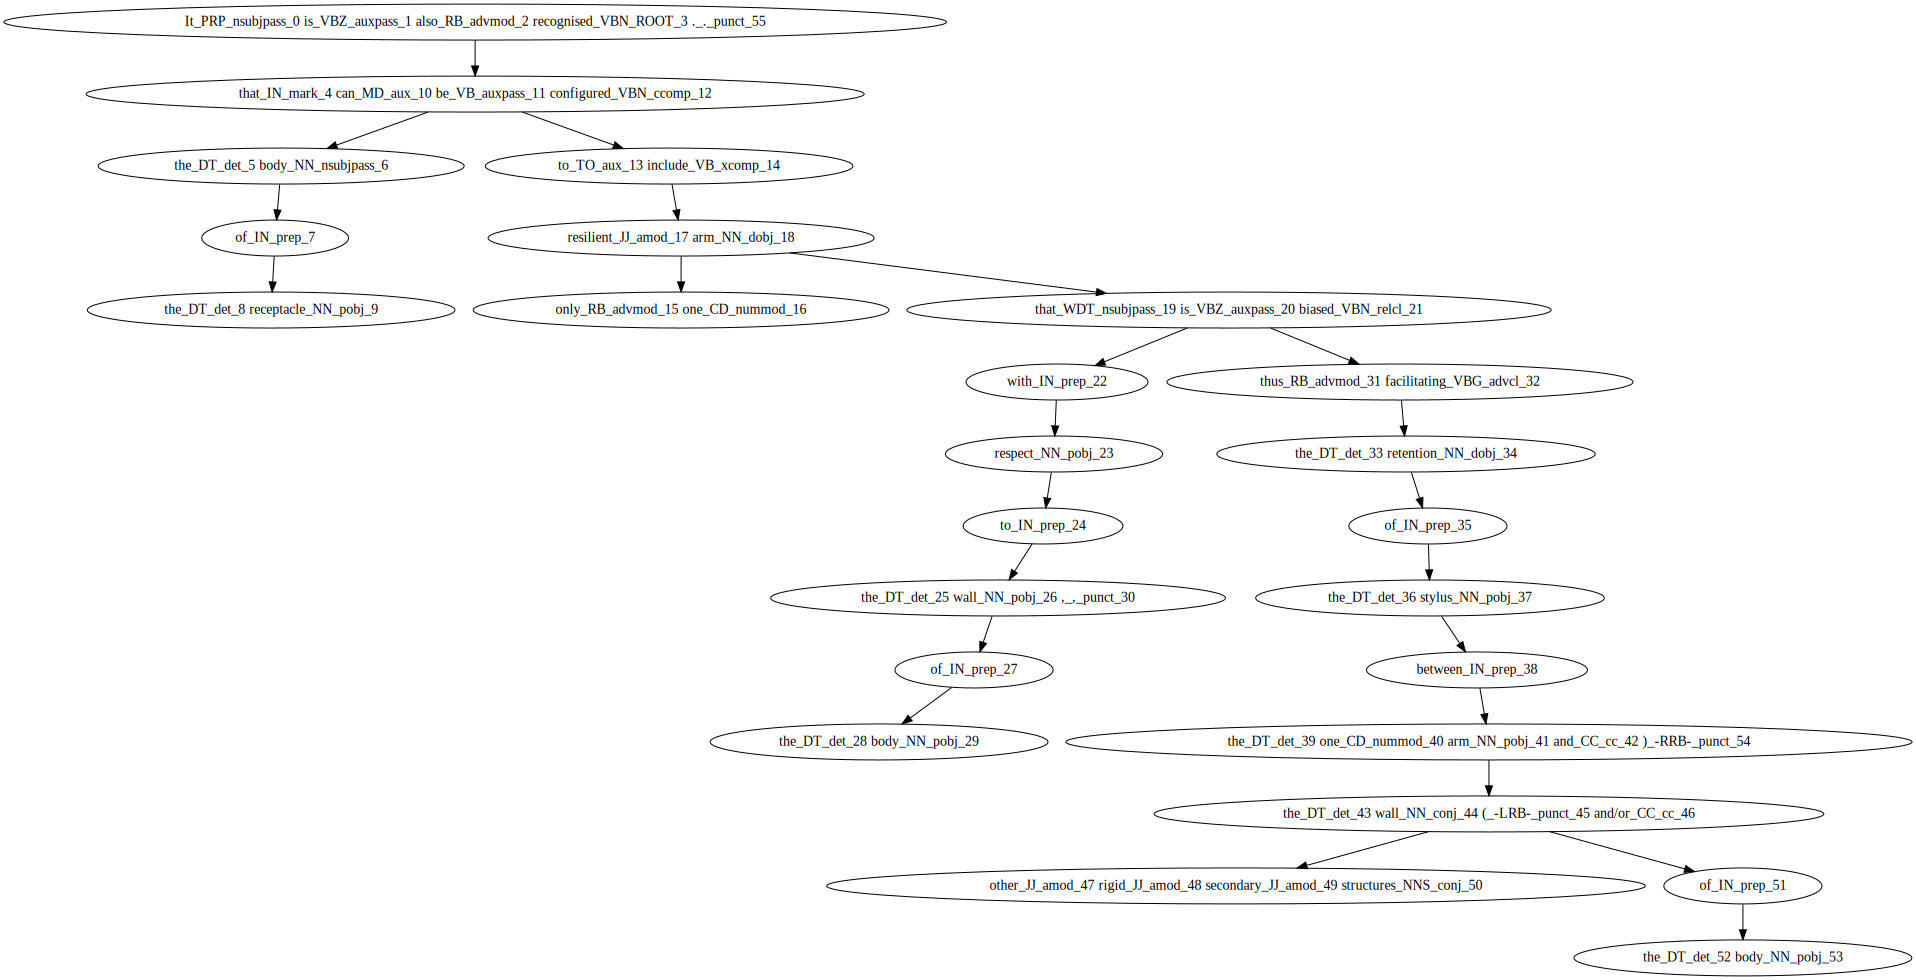

In [131]:
g_copy.get_graphviz()

Now we collapse the single path lines.

In [ ]:
g_copy = Graph(root)

nodes_to_pop = []
for node in g_copy.nodes:
    # Get nodes connected to current node
    children = g_copy._Graph__graph_dict[node]
    #print(node)
    #print(children)
    children_to_remove = []
    # Iterate through connected nodes
    for child in children:
        #print(child)
        # If connected node has no children
        if not g_copy._Graph__graph_dict[child]:
            g_copy.merge_nodes(node, child)
            nodes_to_pop.append(child)
for ntp in nodes_to_pop:
    g_copy.remove_node(ntp)

In [121]:
for node in g_copy.nodes:
    print(node.tokens)

[also, is, It, recognised, .]
[be, can, that, configured]
[the, body]
[of]
[the, receptacle]
[to, include]
[resilient, arm]
[only, one]
[is, that, biased]
[with]
[respect]
[to]
[the, wall, ,]
[of]
[the, body]
[thus, facilitating]
[the, retention]
[of]
[the, stylus]
[between]
[one, the, arm, and, )]
[the, wall, (, and/or]
[secondary, rigid, other, structures]
[of]
[the, body]


In [125]:
g_copy.nodes[0].tokens.sort(key=lambda x: x.i)

In [126]:
g_copy.nodes[0].tokens

[It, is, also, recognised, .]

g.nodes is set initially but we are popping the entry.

Instead we need to make a list of nodes to pop and do this at the end

In [55]:
g_copy._Graph__token_dict

OrderedDict([('recognised_VBN_ROOT_3', recognised),
             ('configured_VBN_ccomp_12', configured),
             ('body_NN_nsubjpass_6', body),
             ('of_IN_prep_7', of),
             ('receptacle_NN_pobj_9', receptacle),
             ('include_VB_xcomp_14', include),
             ('arm_NN_dobj_18', arm),
             ('one_CD_nummod_16', one),
             ('biased_VBN_relcl_21', biased),
             ('with_IN_prep_22', with),
             ('respect_NN_pobj_23', respect),
             ('to_IN_prep_24', to),
             ('wall_NN_pobj_26', wall),
             ('of_IN_prep_27', of),
             ('body_NN_pobj_29', body),
             ('facilitating_VBG_advcl_32', facilitating),
             ('retention_NN_dobj_34', retention),
             ('of_IN_prep_35', of),
             ('stylus_NN_pobj_37', stylus),
             ('between_IN_prep_38', between),
             ('arm_NN_pobj_41', arm),
             ('wall_NN_conj_44', wall),
             ('structures_NNS_conj_50', str

In [69]:
g_copy.nodes

['recognised_VBN_ROOT_3',
 'configured_VBN_ccomp_12',
 'body_NN_nsubjpass_6',
 'of_IN_prep_7',
 'receptacle_NN_pobj_9',
 'include_VB_xcomp_14',
 'arm_NN_dobj_18',
 'one_CD_nummod_16',
 'biased_VBN_relcl_21',
 'with_IN_prep_22',
 'respect_NN_pobj_23',
 'to_IN_prep_24',
 'wall_NN_pobj_26',
 'of_IN_prep_27',
 'body_NN_pobj_29',
 'facilitating_VBG_advcl_32',
 'retention_NN_dobj_34',
 'of_IN_prep_35',
 'stylus_NN_pobj_37',
 'between_IN_prep_38',
 'arm_NN_pobj_41',
 'wall_NN_conj_44',
 'structures_NNS_conj_50',
 'of_IN_prep_51',
 'body_NN_pobj_53']

In [70]:
g_copy.edges

[('recognised_VBN_ROOT_3', 'configured_VBN_ccomp_12'),
 ('configured_VBN_ccomp_12', 'body_NN_nsubjpass_6'),
 ('configured_VBN_ccomp_12', 'include_VB_xcomp_14'),
 ('body_NN_nsubjpass_6', 'of_IN_prep_7'),
 ('of_IN_prep_7', 'receptacle_NN_pobj_9'),
 ('include_VB_xcomp_14', 'arm_NN_dobj_18'),
 ('arm_NN_dobj_18', 'one_CD_nummod_16'),
 ('arm_NN_dobj_18', 'biased_VBN_relcl_21'),
 ('biased_VBN_relcl_21', 'with_IN_prep_22'),
 ('biased_VBN_relcl_21', 'facilitating_VBG_advcl_32'),
 ('with_IN_prep_22', 'respect_NN_pobj_23'),
 ('respect_NN_pobj_23', 'to_IN_prep_24'),
 ('to_IN_prep_24', 'wall_NN_pobj_26'),
 ('wall_NN_pobj_26', 'of_IN_prep_27'),
 ('of_IN_prep_27', 'body_NN_pobj_29'),
 ('facilitating_VBG_advcl_32', 'retention_NN_dobj_34'),
 ('retention_NN_dobj_34', 'of_IN_prep_35'),
 ('of_IN_prep_35', 'stylus_NN_pobj_37'),
 ('stylus_NN_pobj_37', 'between_IN_prep_38'),
 ('between_IN_prep_38', 'arm_NN_pobj_41'),
 ('arm_NN_pobj_41', 'wall_NN_conj_44'),
 ('wall_NN_conj_44', 'structures_NNS_conj_50'),
 ('w

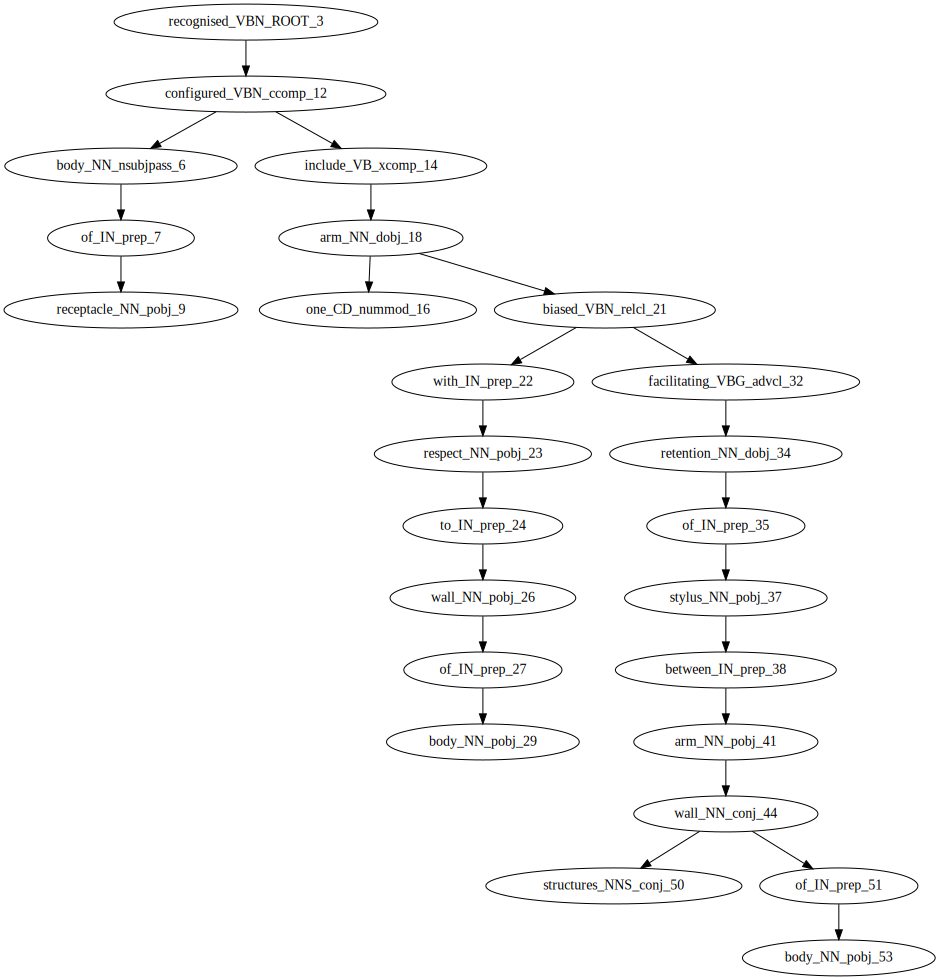

In [71]:
g_copy.get_graphviz()

Also need to get rid of the edge when removing the node.

In [ ]:
self = g_copy
gv = graphviz.Digraph()
for node in self.nodes:
    node_text = " ".join.([t.text for t in self.__layer_dict])
    gv.node(node_text)
for node1, node2 in self.edges:
    gv.edge(node1, node2)
gv